In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gee_scripts.plots import get_ts_plot
from pathlib import Path
import pandas as pd

import seaborn as sns
import geopandas as gpd

import matplotlib.pyplot as plt

In [3]:
#---------------------------------------------------
# for plotting purposes we use this iPython magic
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (19, 19)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 1. Read in the data

In [4]:
explanatory_file_path = "data/7_training_data/explanatory_with_response_var_and_source.csv"
base_df = pd.read_csv(explanatory_file_path)
print("lenght of base_df: ", len(base_df))
# Drop duplicates on id and date
base_df = base_df.drop_duplicates(subset=["id", "date"])
print("lenght of base_df after dropping duplicates: ", len(base_df))

# Find if there are any NaNs and remove them from the dataset 
# Some NAN values are still present in the dataset, probably due to the fact that some of the
# points fall outside bounds of GLDSA dataset
base_df = base_df[~base_df.isna().any(axis=1)]

print("lenght of base_df after droping any nan values: ", len(base_df))

lenght of base_df:  33420
lenght of base_df after dropping duplicates:  32577
lenght of base_df after droping any nan values:  31554


## 2. Add regions to the points

<center><img src="img/training_regions.png" alt="image" width="900"/></center>
<p>Below we will add the region attribute to each of the points, this will be useful if we want to train different models over different subsets.</p>

In [5]:
shp_path = Path("data/0_shp/")
region_path = "regions_to_request_explanatory_all.gpkg"
gdf_regions = gpd.GeoDataFrame.from_file(shp_path/region_path)

unique_coords = base_df[["id", 'lon', 'lat']].drop_duplicates()
len(base_df), len(unique_coords)

# Create geodataframe from x y coordinates
station_with_region_df = gpd.GeoDataFrame(unique_coords, geometry=gpd.points_from_xy(unique_coords.lon, unique_coords.lat), crs="EPSG:4326")

# # Add the region id to each point
station_with_region_df = gpd.sjoin(station_with_region_df, gdf_regions[["region_id", "geometry"]], how="left", predicate="within")

# Merge the region id to the main dataframe
df = base_df.merge(station_with_region_df[["id", "region_id"]], on="id", how="left")

# Convert to GeoDataFrame
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
# Set CRS to WGS84
df.crs = "EPSG:4326"

# read phu regions shapefile
phu_regions = gpd.read_file("data/0_shp/AOI__Province__865_PHUs__INDONESIA.gpkg")

# add phu region to each point
df = gpd.sjoin(df, phu_regions, how="left", predicate="within")


## Exploratory: Get the count of the number of dates for each point

In [6]:
# group by id and get the number of dates for each id
df_grouped = df.groupby("id").count().reset_index()
df_grouped = df_grouped[["id", "date"]]
df_grouped.columns = ["id", "date_count"]
df_grouped.sort_values(by="date_count", ascending=False)

id  date_count
1968        BRG_150710_03         261
1957        BRG_140806_01         228
1967        BRG_150710_02         226
745      15_RAPP_PPDV-05a         212
779    15_RAPP_PPDVIII-23         206
...                   ...         ...
896   15_RAPP_SKM/XIII-04           1
895   15_RAPP_SKM/XII-15a           1
894   15_RAPP_SKM/XII-14a           1
893    15_RAPP_SKM/XII-13           1
197    10_MTI_MTI_H077_P3           1

[2044 rows x 2 columns]

<Axes: xlabel='region_id', ylabel='gwl_cm'>

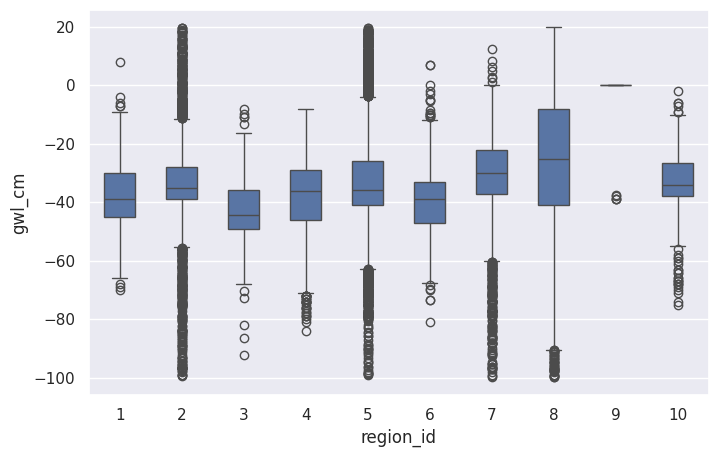

In [7]:
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="region_id", y="gwl_cm", data=df, width=0.5)

# 3. Identify outliers


When dealing with outliers in data, it's essential to adopt a systematic approach, and there are various statistical methods to identify and handle them. Here are some commonly used techniques to detect and remove outliers:

### Z-Score:

The Z-score represents the number of standard deviations a data point is from the mean.
Typically, if the Z-score is greater than 3 or less than -3, the data point can be classified as an outlier.


### Interquartile Range (IQR):

The IQR is the range between the first quartile (25th percentile) and the third quartile (75th percentile) of the data.
Data points that lie 1.5 times the IQR below the first quartile or above the third quartile can be classified as outliers.

### Visual Methods:

Box plots (as you've shown) can visually represent outliers.
Scatter plots can also help visualize outliers in multi-dimensional data.


### Domain Knowledge:

Sometimes, domain expertise can provide thresholds beyond which values are implausible.


### Check regions 3 and 9

In [8]:
# Create descriptive statistics
df_region_3 = df[df.region_id == 3]
df_region_9 = df[df.region_id == 9]

problematic_regions = [3, 9]

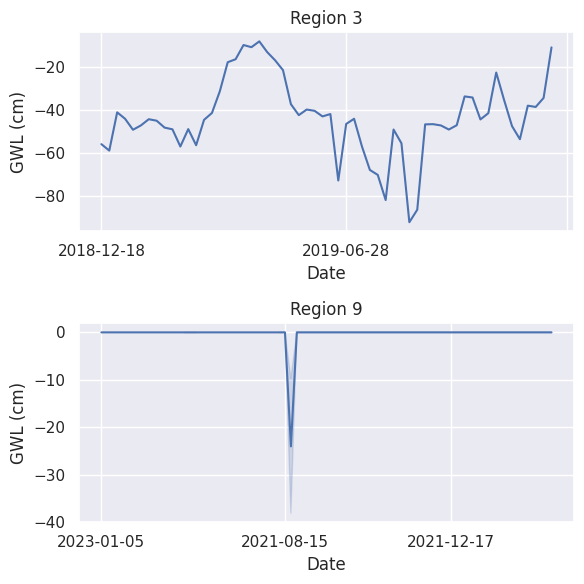

In [9]:
from matplotlib.dates import MonthLocator


# Set the figure size
fig, axs = plt.subplots(len(problematic_regions), 1, figsize=(6, 3*len(problematic_regions)))

# Iterate over the region IDs and create a separate plot for each region
for i, region_id in enumerate(problematic_regions):
    ax = axs[i]
    sns.lineplot(x="date", y="gwl_cm", data=df[df.region_id==region_id], ax=ax)
    ax.set_title(f"Region {region_id}")
    ax.set_xlabel("Date")
    ax.set_ylabel("GWL (cm)")

    # Use MonthLocator for sparse labeling
    ax.xaxis.set_major_locator(MonthLocator())


# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plots
plt.show()

## Discuss: Does the displayed values for this point make sense?

- Consider to remove any of the problematic regions.

In [10]:
df = df[~df.region_id.isin([9])]

<Axes: xlabel='region_id', ylabel='gwl_cm'>

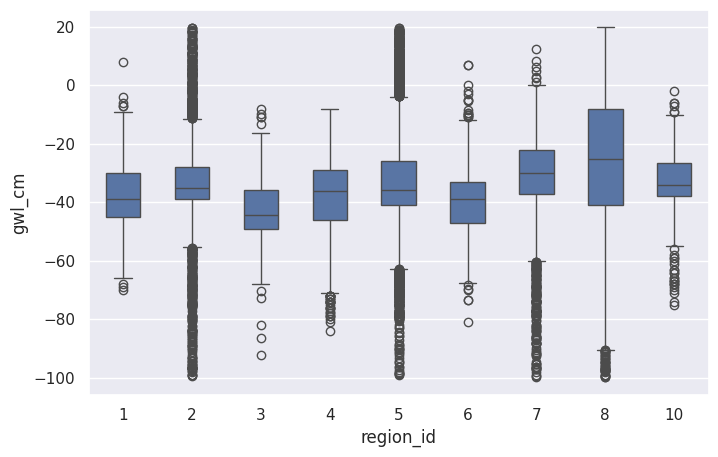

In [11]:
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="region_id", y="gwl_cm", data=df, width=0.5)

In [12]:
# Calculate Q1 and Q3 for each region
Q1 = df.groupby('region_id')['gwl_cm'].quantile(0.25)
Q3 = df.groupby('region_id')['gwl_cm'].quantile(0.75)

# Calculate IQR for each region
IQR = Q3 - Q1

# Define bounds for outliers for each region
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Map the lower and upper bounds for each region_id in df
df_lower_bound = df['region_id'].map(lower_bound)
df_upper_bound = df['region_id'].map(upper_bound)

# Filter out outliers
filtered_df = df[~((df['gwl_cm'] < df_lower_bound) | (df['gwl_cm'] > df_upper_bound))]
filtered_df

source               id        date  gwl_cm       lat         lon  \
0         pkeg  02_AHL_SBG-B076  2021-06-01   -41.0  3.937760  117.007750   
1         pkeg  02_AHL_SBG-B076  2021-08-24   -38.0  3.937760  117.007750   
2         pkeg  02_AHL_SBG-B076  2022-04-09   -22.0  3.937760  117.007750   
3         pkeg  02_AHL_SBG-B076  2023-02-15   -31.0  3.937760  117.007750   
7         pkeg  02_AHL_SBG-B101  2022-04-09   -34.0  3.931860  117.010120   
...        ...              ...         ...     ...       ...         ...   
31549  old_brg         kalteng1  2020-02-24   -23.9 -2.319728  114.058131   
31550  old_brg         kalteng1  2020-03-07   -31.1 -2.319728  114.058131   
31551  old_brg         kalteng1  2020-03-19   -14.7 -2.319728  114.058131   
31552  old_brg         kalteng1  2020-03-31   -27.1 -2.319728  114.058131   
31553  old_brg         kalteng1  2020-04-12   -11.4 -2.319728  114.058131   

             LIA         VH         VV  VVVH_ratio  ...  doy  region_id  \
0      32.785855 -11.481278  -5.556430    0.207099  ...  152         10   
1      32.785295 -12.812067  -5.960235    0.201164  ...  236         10   
2      32.795191 -18.437775 -10.636812    0.072032  ...   99         10   
3      32.793740 -13.051827  -9.007584    0.076149  ...   46         10   
7      39.270480 -16.941989 -10.601523    0.066845  ...   99         10   
...          ...        ...        ...         ...  ...  ...        ...   
31549  32.478706 -12.878587  -8.271499    0.097345  ...   55          8   
31550  32.478589 -13.078360  -6.593164    0.169898  ...   67          8   
31551  32.479968 -12.563061  -7.793232    0.110794  ...   79          8   
31552  32.480674 -13.179518  -7.523130    0.128794  ...   91          8   
31553  32.474638 -12.679995  -7.348031    0.130210  ...  103          8   

                         geometry  index_right      island  \
0       POINT (117.00775 3.93776)        189.0  Kalimantan   
1       POINT (117.00775 3.93776)        189.0  Kalimantan   
2       POINT (117.00775 3.93776)        189.0  Kalimantan   
3       POINT (117.00775 3.93776)        189.0  Kalimantan   
7       POINT (117.01012 3.93186)        189.0  Kalimantan   
...                           ...          ...         ...   
31549  POINT (114.05813 -2.31973)        137.0  Kalimantan   
31550  POINT (114.05813 -2.31973)        137.0  Kalimantan   
31551  POINT (114.05813 -2.31973)        137.0  Kalimantan   
31552  POINT (114.05813 -2.31973)        137.0  Kalimantan   
31553  POINT (114.05813 -2.31973)        137.0  Kalimantan   

                 province                              phu_name      aoi_phu  \
0        North Kalimantan  KHG Sungai Sebuku - Sungai Sembakung  KAL_User_15   
1        North Kalimantan  KHG Sungai Sebuku - Sungai Sembakung  KAL_User_15   
2        North Kalimantan  KHG Sungai Sebuku - Sungai Sembakung  KAL_User_15   
3        North Kalimantan  KHG Sungai Sebuku - Sungai Sembakung  KAL_User_15   
7        North Kalimantan  KHG Sungai Sebuku - Sungai Sembakung  KAL_User_15   
...                   ...                                   ...          ...   
31549  Central Kalimantan  KHG Sungai Kahayan - Sungai Sebangau  KAL_User_12   
31550  Central Kalimantan  KHG Sungai Kahayan - Sungai Sebangau  KAL_User_12   
31551  Central Kalimantan  KHG Sungai Kahayan - Sungai Sebangau  KAL_User_12   
31552  Central Kalimantan  KHG Sungai Kahayan - Sungai Sebangau  KAL_User_12   
31553  Central Kalimantan  KHG Sungai Kahayan - Sungai Sebangau  KAL_User_12   

       tile_id  phu_id  
0         15.0   189.0  
1         15.0   189.0  
2         15.0   189.0  
3         15.0   189.0  
7         15.0   189.0  
...        ...     ...  
31549     12.0   137.0  
31550     12.0   137.0  
31551     12.0   137.0  
31552     12.0   137.0  
31553     12.0   137.0  

[29768 rows x 43 columns]

<Axes: title={'center': 'GWL distribution after percentile outlier removal'}, xlabel='region_id', ylabel='gwl_cm'>

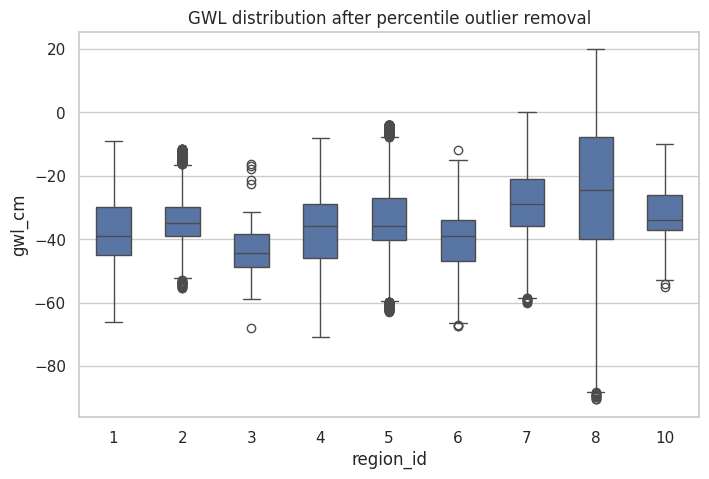

In [13]:
# set the seaborn style and size
sns.set_style("whitegrid")

# give a title
plt.title("GWL distribution after percentile outlier removal")

sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="region_id", y="gwl_cm", data=filtered_df, width=0.5)

## Question: What to do with values above 0?

- Could you explain the values above 0? how are the devices placed?

In [14]:
filtered_df.columns

Index(['source', 'id', 'date', 'gwl_cm', 'lat', 'lon', 'LIA', 'VH', 'VV',
       'VVVH_ratio', 'angle', 'sm_1', 'sm_3', 'sm_7', 'sm_30', 'precipitation',
       'prec_3', 'prec_7', 'prec_30', 'elevation', 'aspect', 'slope',
       'land_cov', 'canopy_height', 'gldas_mean', 'gldas_stddev', 'B3', 'B4',
       'B5', 'B7', 'ndvi', 'ndmi', 'ndbri', 'doy', 'region_id', 'geometry',
       'index_right', 'island', 'province', 'phu_name', 'aoi_phu', 'tile_id',
       'phu_id'],
      dtype='object')

## Plot GWL_cm vs PHU

Plotting time series for region_id...


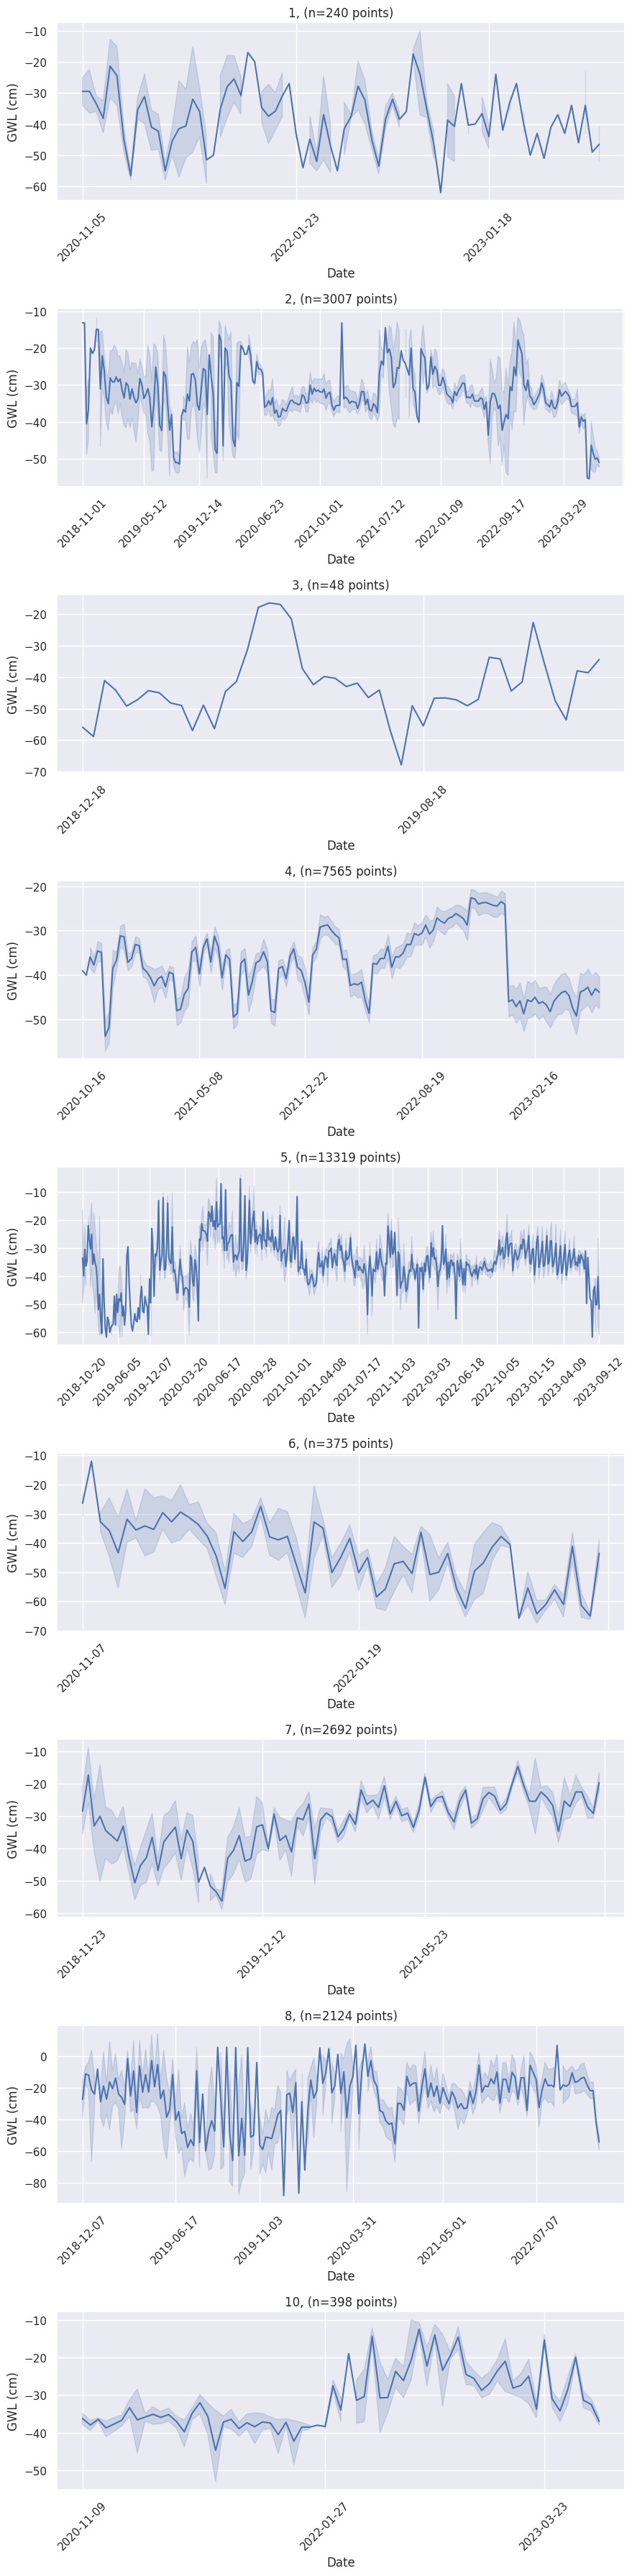

In [15]:

get_ts_plot(filtered_df, y_axis="gwl_cm", group_by="region_id", group_name="region_id")

## Plot GWL_cm vs PHU

Plotting time series for phu_id...


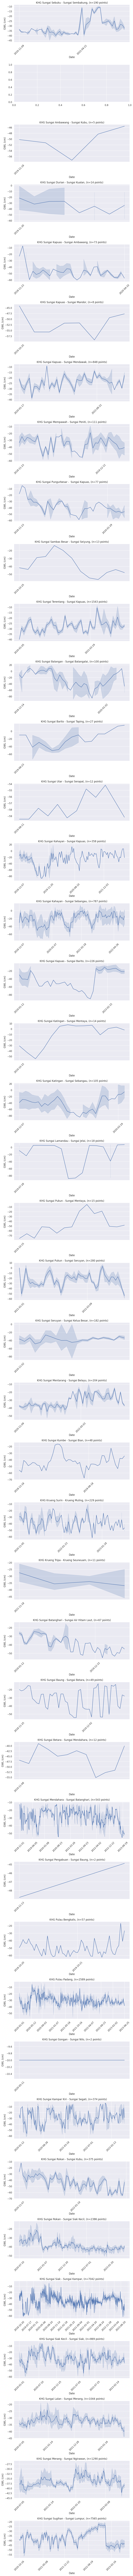

In [16]:
get_ts_plot(filtered_df, y_axis="gwl_cm", group_by="phu_id", group_name="phu_name")

# 3.1 Use the Domain Knowledge to further filter the data (if required)

Visually, does this data make sense?

# 3.2 Remove 

# 4. Export the cleaned dataset to a CSV file

In [18]:
filtered_df.to_csv("data/9_clean_training_data/clean_training_data.csv", index=False)